In [20]:
import xgboost as xgb
import sklearn
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
import numpy as np
from numpy import *
from numpy import mat
import time
import pandas as pd

trainmatrix=np.array(zeros((288*34,228)),dtype=float)
testmatrix=np.array(zeros((80*228,12)),dtype=float)

def as_num(x):
    l=len(x)
    y=[]
    for i in range(l):
        if str(x[i])[-4:]=="e+01" or str(x[i])[-5:-1]=="e+01":
            y.append(np.float32(x[i][:-5])*10)
        else:
            y.append(np.float32(x[i]))
    return(y)


for i in range(34):
    name="./data/train/"+str(i)+".csv"
    traincontext=open(name,"r")
    for j in range(288):
        speed=traincontext.readline()
        trainmatrix[i*288+j,:]=as_num((speed.split("\n")[0]).split(","))
        
distfile=open("./data/distance.csv","r")

def as_int(x):
    l=len(x)
    y=[]
    for i in range(l):
        if str(x[i])[-4:]=="e+03" or str(x[i])[-5:-1]=="e+03":
            y.append(int(float(x[i][:-5])*10000+0.5)/10)
            continue
        if str(x[i])[-4:]=="e+04" or str(x[i])[-5:-1]=="e+04":
            y.append(int(float(x[i][:-5])*100000+0.5)/10)
            continue
        if str(x[i])[-4:]=="e+05" or str(x[i])[-5:-1]=="e+05":
            y.append(int(float(x[i][:-5])*1000000+0.5)/10)
            continue
        if str(x[i])[-4:]=="e+02" or str(x[i])[-5:-1]=="e+02":
            y.append(int(float(x[i][:-5])*1000+0.5)/10)
            continue
        if str(x[i])[-4:]=="e+01" or str(x[i])[-5:-1]=="e+01":
            y.append(int(float(x[i][:-5])*10+0.5)/10)
            continue
        y.append(0)
    return(y)

k0=80  #15,25

near=np.array(zeros((228,k0+1)),dtype=int)
neardst=np.array(zeros((228,k0+1)),dtype=int)
for i in range(228):
    line=distfile.readline()
    dist=as_int(line.split(","))
    for j in range(k0+1):
        m=np.min(dist)
        k=dist.index(m)
        near[i,j]=k
        neardst[i,j]=m
        dist[k]=100000
    if near[i,0]!=i:
        near[i,0],near[i,1]=near[i,1],near[i,0]
    
print(near)

predict=[0 for i in range(54720)]
Xgroup=[1 for i in range(9112)]
for i in range(8000,9112):
    Xgroup[i]=0
Xgroup = np.array(Xgroup)

err=0
errx=0
time_start = time.time()

true15, pred15, true30, pred30, true45, pred45 = [], [], [], [], [], []

time_len = 9112 #268*34
for i in range(150):
    ### 训练、验证、测试数据集 ###
    Xtrain = np.array(np.zeros((time_len, 12*k0+12)), dtype=float)
    Ytrain15 = np.array(np.zeros((time_len)), dtype=float)
    Ytrain30 = np.array(np.zeros((time_len)), dtype=float)
    Ytrain45 = np.array(np.zeros((time_len)), dtype=float)
    Xtest=np.array(zeros((80,12*k0+12)),dtype=float)
    step=0
    for k in range(34):
        for j in range(k*288,(k+1)*288-20):
            Xtrain[step,0:12] = np.transpose(trainmatrix[j:(j+12), i])
            for l in range(k0):
                Xtrain[step, (l*12+12):(12*l+24)]=np.transpose(trainmatrix[j:(j+12),near[i,l+1]])
            Ytrain15[step] = trainmatrix[j+14,i]
            Ytrain30[step] = trainmatrix[j+17,i]
            Ytrain45[step] = trainmatrix[j+20,i]
            step+=1
    
    other_params = {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'objective': 'reg:squarederror', 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.1}

    Xval=Xtrain[Xgroup==0]
    Xtrain=Xtrain[Xgroup>=1]
    Yval15=Ytrain15[Xgroup==0]
    Ytrain15=Ytrain15[Xgroup>=1]
    Yval30=Ytrain30[Xgroup==0]
    Ytrain30=Ytrain30[Xgroup>=1]
    Yval45=Ytrain45[Xgroup==0]
    Ytrain45=Ytrain45[Xgroup>=1]
    
    model=xgb.XGBRegressor(**other_params)
    model.fit(Xtrain, Ytrain15)
    p15 = model.predict(Xval)
    diff = p15 - Yval15
    errx += mean(diff*diff)
    true15.append(Yval15)
    pred15.append(p15)
    print(time.time()-time_start)
        
    model=xgb.XGBRegressor(**other_params)
    model.fit(Xtrain, Ytrain30)
    p30 = model.predict(Xval)
    diff = p30 - Yval30
    errx += mean(diff*diff)
    true30.append(Yval30)
    pred30.append(p30)
    print(time.time()-time_start)
        
    model=xgb.XGBRegressor(**other_params)
    model.fit(Xtrain, Ytrain45)
    p45 = model.predict(Xval)
    diff = p45 - Yval45
    errx += mean(diff*diff)
    true45.append(Yval45)
    pred45.append(p45)
    print(time.time()-time_start)
    
    print(" i = ", i)
    print(" errorx = ", (errx/3/(3))**0.5)
    
#     fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[20,5])
#     ax1, ax2, ax3 = axes.ravel()
#     visual(ax1, Yval15[:500], p15[:500], 15)
#     visual(ax2, Yval30[:500], p30[:500], 30)
#     visual(ax3, Yval45[:500], p45[:500], 45)
# #     plt.savefig("../../Writing/traffic_prediction/fig/XGB_compare_%s.jpg"%i)
#     plt.show()
# dataframe = pd.DataFrame({'True':true15})
# dataframe.to_csv("./print_predict%s.csv"%k0)

[[  0 129   7 ...  17  31 140]
 [  1   7 132 ...  69  16  45]
 [  2  12   4 ...  22 131  26]
 ...
 [225 153 223 ... 184 222 157]
 [226 200 204 ...  58  65  68]
 [227 224 220 ... 158 127   8]]
23.340911626815796
43.80515193939209
66.94064593315125
 i =  0
 errorx =  5.070409091293457
89.99003958702087
110.1872034072876
132.81767344474792
 i =  1
 errorx =  6.78859286187269
155.90793800354004
175.99040818214417
196.051855802536
 i =  2
 errorx =  7.961639137379866
219.7271430492401
239.78169417381287
259.59937715530396
 i =  3
 errorx =  8.396470525982732
282.7926080226898
304.21615266799927
324.4273147583008
 i =  4
 errorx =  9.262983587741761
347.7830877304077
368.2124750614166
388.70341968536377
 i =  5
 errorx =  10.346878624967061
413.8229396343231
436.72798109054565
457.249840259552
 i =  6
 errorx =  11.624401986370486
480.55721068382263
500.96826434135437
521.4399335384369
 i =  7
 errorx =  12.36690483160817
544.9320771694183
568.3439629077911
588.6765639781952
 i =  8
 errorx 

KeyboardInterrupt: 

In [7]:
print(len(true15))

2


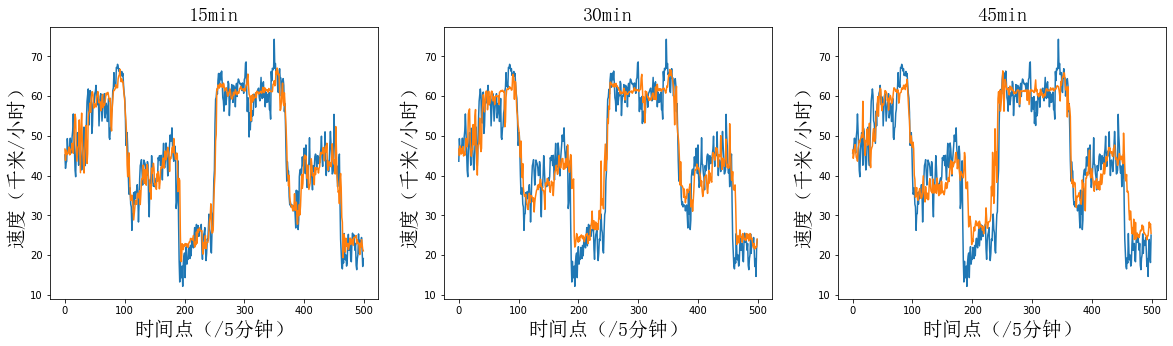

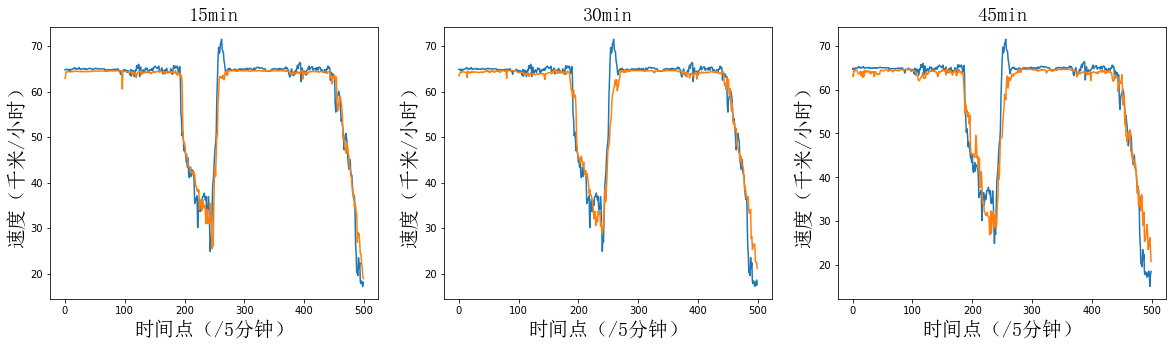

In [9]:
from matplotlib.font_manager import FontProperties
font_set = FontProperties(fname=r"/usr/share/fonts/myfonts/SIMSUN.TTC", size=12)

def visual(ax,true, pred, pre_len):
    ax.plot(true)
    ax.plot(pred)
    ax.set_xlabel('时间点（/5分钟）',fontproperties=font_set, fontsize=20)
    ax.set_ylabel('速度（千米/小时）',fontproperties=font_set, fontsize=20)
    ax.set_title('%smin'%pre_len,fontproperties=font_set, fontsize=20)
#     color =plt.cm.Set2(random.choice(xrange(plt.cm.Set2.N)))

for i in range(2):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[20,5])
    ax1, ax2, ax3 = axes.ravel()
    visual(ax1, true15[i][:500], pred15[i][:500], 15)
    visual(ax2, true30[i][:500], pred30[i][:500], 30)
    visual(ax3, true45[i][:500], pred45[i][:500], 45)
    if i == 0:
        plt.savefig("../../Writing/traffic_prediction/fig/XGB_compare_36.jpg")
        plt.show()

# ax1.plot(true15)
# ax1.plot(pred15)
# ax2.plot(true30)
# ax2.plot(pred30)
# ax3.plot(true45)
# ax3.plot(pred45)


In [ ]:

'''
除了使用matplotlib创建标准统计图，还可以使用panda来创建其他类型的统计图
本例实现：利用panda创建一个条形图和箱线图，并将它们并排放置
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
#创建一个基础图和两个子图
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=[12,8])
#使用ravel()函数将两个子图分别赋给两个变量ax1和ax2，这样可以避免是使用行和列的索引
ax1 = axes#.ravel()
k = [[5.72,5.39],[5.64,5.29],[5.63,5.25],[5.63,5.24],[2.1,3.2],[5.59,5.35]]
k = np.array(k)
data_frame = pd.DataFrame(k,index=['20','50','80','100','150','227'],
                          columns=pd.Index(['验证集','测试集'],name='Metric'))
#创建条形图并设置相关属性

data_frame.plot(kind='bar',ax=ax1,alpha=0.75)
plt.legend(prop=font_set,fontsize=20)
plt.setp(ax1.get_xticklabels(),rotation=0,fontsize=10)
plt.setp(ax1.get_yticklabels(),rotation=0,fontsize=10)
ax1.set_xlabel('邻域个数',fontproperties=font_set, fontsize=20)
ax1.set_ylabel('RMSE',fontproperties=font_set, fontsize=20)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim((4.5,6.0))
#创建箱线图并设置相关属性
# colors = dict(boxes='DarkBlue',whiskers='Gray',medians='Red',caps='Black')
# data_frame.plot(kind='box',color=colors,sym='r.',ax=ax2,title='Box Plot')
# plt.setp(ax2.get_xticklabels(),rotation=45,fontsize=10)
# plt.setp(ax2.get_yticklabels(),rotation=0,fontsize=10)
# ax2.set_xlabel('Metric')
# ax2.set_ylabel('Value')
# ax2.xaxis.set_ticks_position('bottom')
# ax2.yaxis.set_ticks_position('left')
# plt.savefig('pandas_plots.png',dpi=400,bbox_inches='tight')
plt.show()

In [28]:
import numpy.linalg as la
from sklearn.metrics import mean_squared_error,mean_absolute_error
def evaluation(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a, b)
    F_norm = la.norm(a-b)/la.norm(a)
    r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a-b))/np.var(a)
    print('rmse',rmse,'mae',mae,'r2', r2,'var',var,'accuracy',1-F_norm,)
    return rmse, mae, r2, var#, 1-F_norm

print(evaluation(np.array(true15).flatten(), np.array(pred15).flatten()))
print(evaluation(np.array(true30).flatten(), np.array(pred30).flatten()))
print(evaluation(np.array(true45).flatten(), np.array(pred45).flatten()))

rmse 4.639769242526307 mae 2.658276831511052 r2 0.8943377390416516 var 0.8944833972803178 accuracy 0.9211695844573045
(4.639769242526307, 2.658276831511052, 0.8943377390416516, 0.8944833972803178)
rmse 6.14088102841961 mae 3.4828157203400245 r2 0.8152800304555718 var 0.81537300412075 accuracy 0.8956690737860603
(6.14088102841961, 3.4828157203400245, 0.8152800304555718, 0.81537300412075)
rmse 6.878521265600713 mae 3.9449516119599424 r2 0.7684867085346203 var 0.7685123806689587 accuracy 0.8831527943736242
(6.878521265600713, 3.9449516119599424, 0.7684867085346203, 0.7685123806689587)
